# PINN Solution of the Nonlinear Shroedinger PDE

This PyTorch code demonstrates the application of physically-informed neural networks (PINN) in the solution of a well-known Nonlinear Shroedinger PDE with periodic boundary condition
\begin{aligned}
  &\mathbf{u}_t = i * \mathbf{u}_{xx} + i * |\mathbf{u}|^2 * \mathbf{u} \in [0, T]\times[-L, L]\\
  &\mathbf{u}(0, x) = \mathbf{u}_0(x), \quad \forall x \in [-L, L] \\
  &\mathbf{u}(t, -L) = \mathbf{u}(t, L), \quad \forall t \in [0, T]
\end{aligned}
where $i^2 = -1$, and $[-L, L]$ covers one full period, i.e. $T = 2L$.  If we let $\mathbf{u} = u + i * v$, then we obtain two PDEs
\begin{aligned}
u_t &= -v_{xx} - (u^2 + v^2) * v \\
v_t &= u_{xx} + (u^2 + v^2) * u
\end{aligned}

## Libraries and Dependencies

In [1]:
import torch
import torch.optim
import torch.optim.lr_scheduler as lr_scheduler
from itertools import chain
from collections import OrderedDict
from pyDOE import lhs
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time

np.random.seed(1234)

In [2]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
#
print(f"Working on {device}")

Working on mps


In [7]:
L = np.pi
xlo = -L
xhi = L
period = xhi - xlo
tlo = 0.0
thi = 2.0
sqrt2 = torch.tensor(np.sqrt(2)).float().to(device)
# taking A = 1 and B = 1
u0 = lambda x: 2.0/(2.0 - np.sqrt(2) * np.cos(x)) - 1.0
v0 = lambda x: np.zeros_like(x)
u0_ten = lambda x: 2.0/(2.0 - sqrt2 * torch.cos(x)) - 1.0
v0_ten = lambda x: torch.zeros_like(x)

## Physics-informed Neural Networks

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        # parameters
        self.depth = len(layers) - 1
        # set up layer order dict
        self.activation = torch.nn.Tanh
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        self.layers[0].weight = torch.load('initial_weight.pt')
    def forward(self, x):
        out = self.layers(x)
        return out

In [8]:
class PhysicsInformedNN():
    def __init__(self, period,  X_IC, u_IC, v_IC, X_BC, u_BC, v_BC, X_PDE, layers):
        # IC data point
        self.t_IC = torch.tensor(X_IC[:, 0:1]).float().to(device)
        self.x_IC = torch.tensor(X_IC[:, 1:2]).float().to(device)
        self.u_IC = torch.tensor(u_IC).float().to(device)
        self.v_IC = torch.tensor(v_IC).float().to(device) 
        # BC data point
        self.t_BC = torch.tensor(X_BC[:, 0:1]).float().to(device)
        self.x_BC = torch.tensor(X_BC[:, 1:2]).float().to(device)
        self.u_BC = torch.tensor(u_BC).float().to(device)
        self.v_BC = torch.tensor(v_BC).float().to(device) 
        self.period = torch.tensor(period).float().to(device)
        # PDE data, gradients will be computed on these points so requires_grad = True
        self.t_PDE = torch.tensor(X_PDE[:, 0:1], requires_grad=True).float().to(device)
        self.x_PDE = torch.tensor(X_PDE[:, 1:2], requires_grad=True).float().to(device)
        # equation related parameters
        
        # layers to build Neural Net
        self.layers = layers
        # deep neural networks
        self.dnn = DNN(layers).to(device)    
        # prepare the optimizer
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), lr = 1e-3)
        # add a learning rate scheduler
        self.optimizer_LBFGS = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=10000, 
            max_eval=5000, 
            history_size=50,
            tolerance_grad=1e-7, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )      
        self.scheduler = lr_scheduler.ExponentialLR(self.optimizer_Adam, gamma=0.99)
        
        
        self.iter = 0
    # evaluater neural network, no transformation
    def NN_eval(self, t, x): 
        NN = self.dnn(torch.cat([t, x], dim = 1)) 
        u = NN[:, 0][:, None]
        v = NN[:, 1][:, None]
        return u, v
    # compute the PDE
    def pde_eval(self, t, x):
        """ The pytorch autograd version of calculating residual """
        u, v = self.NN_eval(t, x)
        # compute the derivatives for u
        u_t    = torch.autograd.grad(u,     t, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        u_x    = torch.autograd.grad(u,     x, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        u_xx   = torch.autograd.grad(u_x,   x, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        v_t    = torch.autograd.grad(v,     t, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        v_x    = torch.autograd.grad(v,     x, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        v_xx   = torch.autograd.grad(v_x,   x, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]   
        # pre-compute the norm of \mathbf{u}, so that it can be re-used
        U_norm = torch.pow(u, 2.0) + torch.pow(v, 2.0)
        Eq1    = u_t + v_xx + U_norm * v
        Eq2    = v_t - u_xx - U_norm * u
        return Eq1, Eq2
    # compute the total loss for the second-order optimizer
    def loss_func(self):
        # reset the gradient
        self.optimizer_LBFGS.zero_grad()
        # compute IC loss
        uIC_pred, vIC_pred = self.NN_eval(self.t_IC, self.x_IC)
        loss_IC = torch.mean((self.u_IC - uIC_pred)**2.0) + torch.mean((self.v_IC - vIC_pred)**2.0)
        # compute PBC loss
        uBC_pred_left, vBC_pred_left = self.NN_eval(self.t_BC, self.x_BC)
        uBC_pred_right, vBC_pred_right = self.NN_eval(self.t_BC, self.x_BC+self.period)
        loss_BC = torch.mean(( uBC_pred_left - uBC_pred_right)**2.0) + torch.mean((vBC_pred_left - vBC_pred_right)**2.0)
        
       
        # compute PDE loss
        pde1_pred, pde2_pred = self.pde_eval(self.t_PDE, self.x_PDE)
        loss_PDE = torch.mean(pde1_pred ** 2) + torch.mean(pde2_pred ** 2)   
        # compute the total loss, it can be weighted
        loss = loss_IC + loss_BC + loss_PDE
        # backward propagation
        loss.backward()
        # increase the iteration counter
        self.iter += 1
        # output
        # output the progress
        if self.iter % 1000 == 0:
            end_time = time.time()
            print('Iter %5d, Total: %10.4e, Time: %.2f secs' % (self.iter, loss.item(), end_time - self.start_time))
            print('IC: %10.4e, PBC: %10.4e, PDE: %10.4e' % (loss_IC.item(), loss_BC.item(), loss_PDE.item()))
            self.start_time = end_time
        return loss
    #
    def train(self, nIter):
        # start the timer
        start_time = time.time()        
        # start the training with Adam first
        self.dnn.train()
        print('Starting with Adam')
        for epoch in range(nIter):
            # compute IC loss
            uIC_pred, vIC_pred = self.NN_eval(self.t_IC, self.x_IC)
            loss_IC = torch.mean((self.u_IC - uIC_pred)**2.0) + torch.mean((self.v_IC - vIC_pred)**2.0)
        # compute PBC loss
            uBC_pred_left, vBC_pred_left = self.NN_eval(self.t_BC, self.x_BC)
            uBC_pred_right, vBC_pred_right = self.NN_eval(self.t_BC, self.x_BC+self.period)
            loss_BC = torch.mean(( uBC_pred_left - uBC_pred_right)**2.0) + torch.mean((vBC_pred_left - vBC_pred_right)**2.0)
        
       
        # compute PDE loss
            pde1_pred, pde2_pred = self.pde_eval(self.t_PDE, self.x_PDE)
            loss_PDE = torch.mean(pde1_pred ** 2) + torch.mean(pde2_pred ** 2)   
        # compute the total loss, it can be weighted
            loss = loss_IC + loss_BC + loss_PDE
            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step() 
            # output the progress
            if (epoch + 1) % 1000 == 0:
                end_time = time.time()
                print('Iter %5d, Total: %10.4e, Time: %.2f secs' % (epoch + 1, loss.item(), end_time - start_time))
                print('IC: %10.4e, PBC: %10.4e, PDE: %10.4e' % (loss_IC.item(), loss_BC.item(), loss_PDE.item()))
                start_time = end_time
                # change the learning rate
                self.scheduler.step()
        # Using the second-order L-BFGS optimizer
#         print('Starting with L-BFGS')
        self.start_time = time.time()
        self.optimizer_LBFGS.step(self.loss_func)                
    #        
    def predict(self, X):
        t = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        x = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.dnn.eval()
        u, v = self.NN_eval(t, x)
        u = u.detach().cpu().numpy()
        v = v.detach().cpu().numpy()
        return u,v


## Training

In [9]:
layers = [2, 32, 32, 32, 32, 32, 32, 32, 2]
N_IC = 128
ptsIC=np.load('ptsIC.npy')
ptsBC=np.load('ptsBC.npy')
ptsPDE=np.load('random_data.npy')
x_IC = np.expand_dims(np.linspace(xlo, xhi, N_IC), axis = 1)
uIC = u0(x_IC)
vIC = v0(x_IC)
uBC = np.load('uBC.npy')
vBC = np.load('vBC.npy')
model = PhysicsInformedNN(period, ptsIC, uIC, vIC, ptsBC, uBC, vBC, ptsPDE, layers)
model.train(50000)

Starting with Adam
Iter  1000, Total: 4.1847e-02, Time: 85.93 secs
IC: 1.7506e-02, PBC: 3.7238e-05, PDE: 2.4304e-02
Iter  2000, Total: 3.1136e-01, Time: 116.08 secs
IC: 2.3158e-01, PBC: 7.3006e-04, PDE: 7.9047e-02
Iter  3000, Total: 1.3308e-01, Time: 115.28 secs
IC: 6.4332e-02, PBC: 3.4915e-03, PDE: 6.5258e-02
Iter  4000, Total: 7.7328e-02, Time: 114.92 secs
IC: 3.8169e-02, PBC: 1.0532e-03, PDE: 3.8106e-02
Iter  5000, Total: 4.7750e-02, Time: 115.01 secs
IC: 2.4613e-02, PBC: 3.5022e-04, PDE: 2.2787e-02
Iter  6000, Total: 3.6599e-02, Time: 115.26 secs
IC: 1.6948e-02, PBC: 2.6294e-04, PDE: 1.9387e-02
Iter  7000, Total: 3.1333e-02, Time: 116.31 secs
IC: 1.3040e-02, PBC: 2.2541e-04, PDE: 1.8068e-02
Iter  8000, Total: 2.7368e-02, Time: 115.06 secs
IC: 1.0781e-02, PBC: 2.0844e-04, PDE: 1.6378e-02
Iter  9000, Total: 2.3439e-02, Time: 116.14 secs
IC: 9.0100e-03, PBC: 1.9851e-04, PDE: 1.4231e-02
Iter 10000, Total: 1.9120e-02, Time: 116.29 secs
IC: 7.3416e-03, PBC: 1.7370e-04, PDE: 1.1605e-02
It

In [10]:
t = np.linspace(tlo, thi, 201)
x = np.linspace(xlo, xhi, 501)
T, X = np.meshgrid(t, x)
pts_flat = np.hstack((T.flatten()[:, None], X.flatten()[:, None]))
u_pred, v_pred = model.predict(pts_flat)           
u_pred = griddata(pts_flat, u_pred.flatten(), (T, X), method='cubic')
v_pred = griddata(pts_flat, v_pred.flatten(), (T, X), method='cubic')

## Visualizations

In [11]:
data = scipy.io.loadmat('/Users/abraham/Desktop/PINN/New_Data/NLS_1D_t2.mat')
t = data['t'].flatten()[:,None]
x2 = data['x'].flatten()[:,None]
u_sol = np.real(data['Exact']).T
v_sol = np.imag(data['Exact']).T

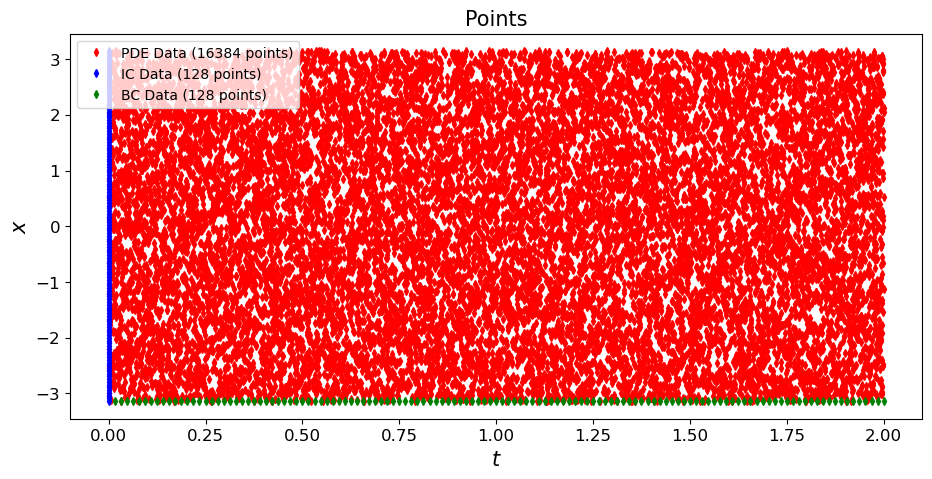

In [12]:
fig = plt.figure(figsize=(11, 5))
ax = fig.add_subplot(1, 1, 1)
#
ax.plot(ptsPDE[:, 0], ptsPDE[:, 1], 
    'rd', label = 'PDE Data (%d points)' % (ptsPDE.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

ax.plot(ptsIC[:, 0], ptsIC[:, 1], 
    'bd', label = 'IC Data (%d points)' % (ptsIC.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)


ax.plot(ptsBC[:, 0], ptsBC[:, 1], 
    'gd', label = 'BC Data (%d points)' % (ptsBC.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

ax.set_xlabel('$t$', size=15)
ax.set_ylabel('$x$', size=15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.legend()
ax.set_title('Points', fontsize = 15) # font size doubled
ax.tick_params(labelsize=12)
#
plt.show()

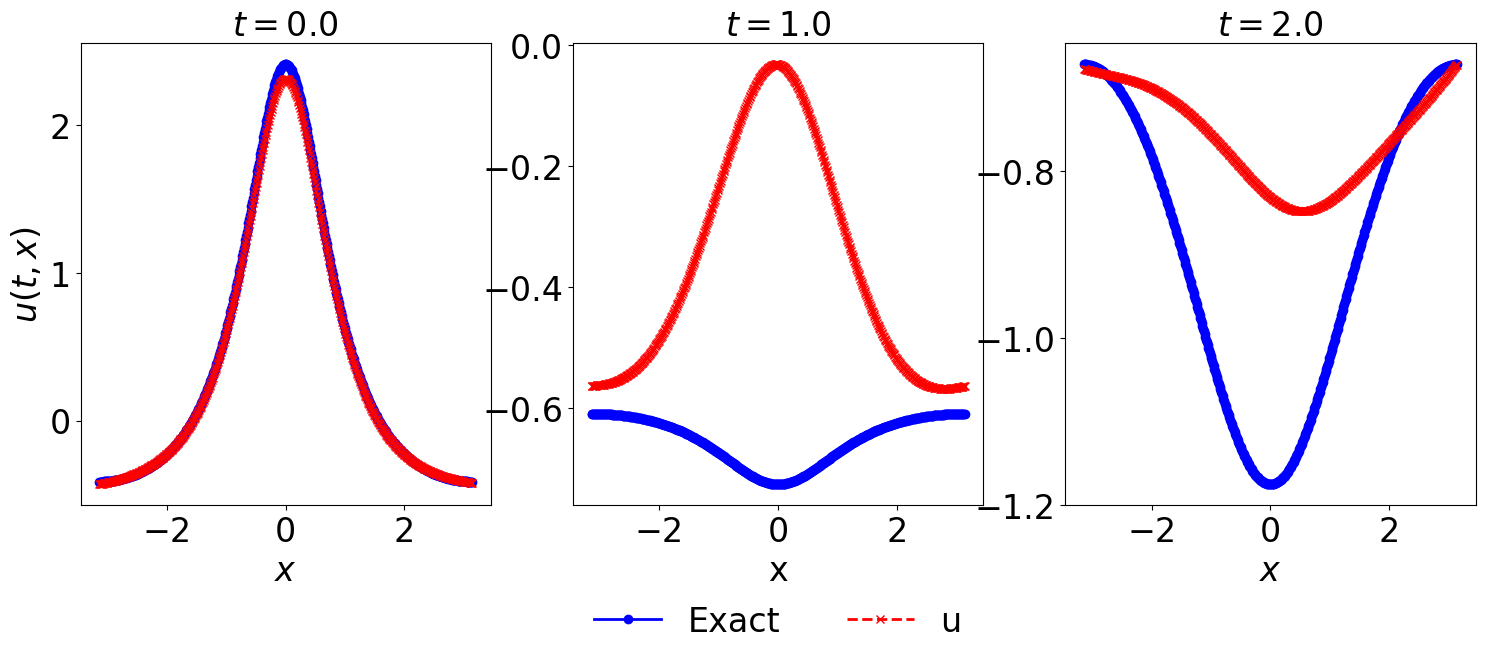

In [27]:
####### Row 1: u(t,x) slices ################## 

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(18, 6))
#
ax = plt.subplot(1, 3, 1)
ax.plot(x2, u_sol[0,:], 'bo-', linewidth = 2, label = 'Exact')       
ax.plot(x, u_pred[:, 0], 'rx--', linewidth = 2, label = 'u')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = %.1f$' %(t[0]), fontsize = 24)


plt.locator_params(axis = 'y', nbins = 5)
plt.locator_params(axis = 'x', nbins = 5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(24)

ax = plt.subplot(1, 3, 2)
ax.plot(x,u_sol[100,:], 'bo-', linewidth = 2, label = 'Exact')       
ax.plot(x, u_pred[:, 100], 'rx--', linewidth = 2, label = 'u')

ax.set_xlabel('x')




ax.set_title('$t = %.1f$' %(t[100]), fontsize = 24)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 24}
)
plt.locator_params(axis = 'y', nbins = 5)
plt.locator_params(axis = 'x', nbins = 5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(24)

ax = plt.subplot(1, 3, 3)
ax.plot(x,u_sol[200,:], 'bo-', linewidth = 2, label = 'Exact')       
ax.plot(x, u_pred[:, 200], 'rx--', linewidth = 2, label = 'u')

ax.set_xlabel('$x$')




ax.set_title('$t = %.1f$' %(t[200]), fontsize = 24)
plt.locator_params(axis = 'y', nbins = 5)
plt.locator_params(axis = 'x', nbins = 5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(24)

plt.show()
fig.savefig('NLSu_1D_BL.png',format='png')

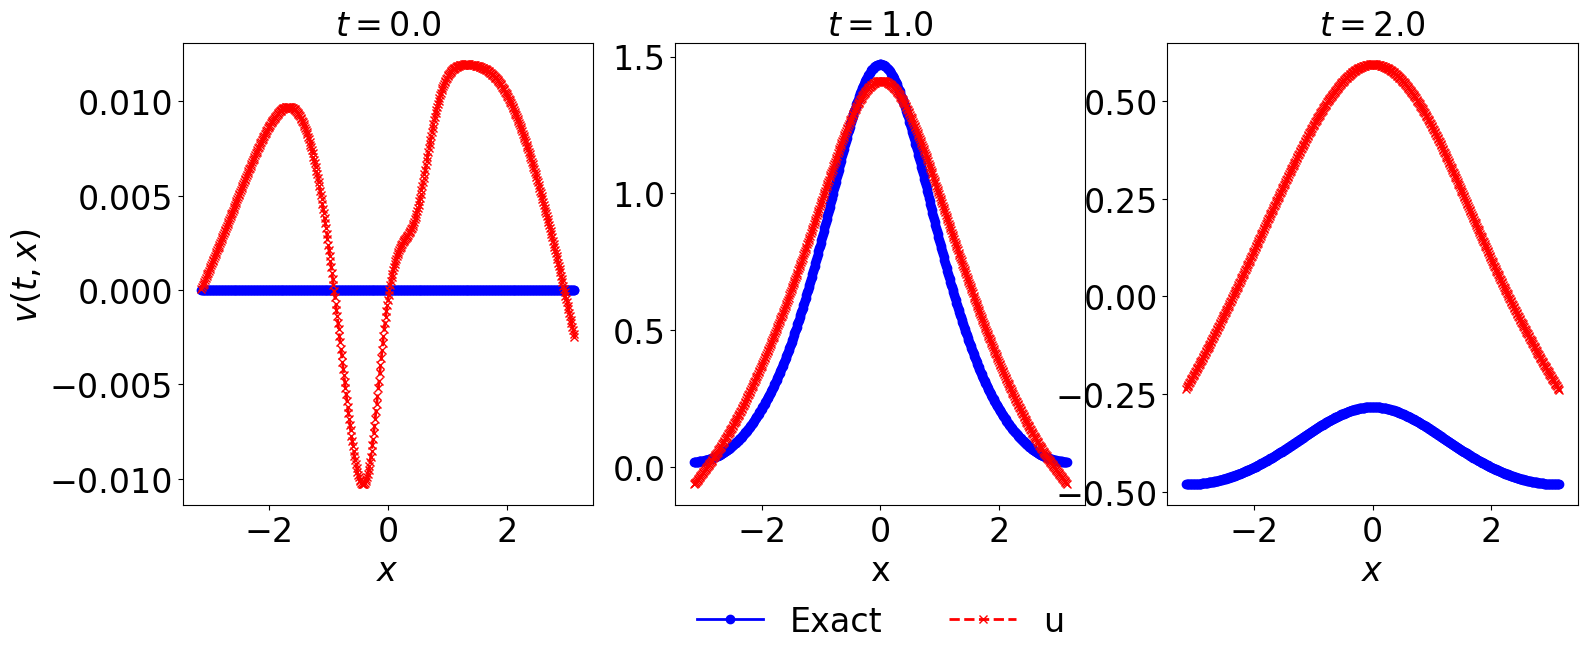

In [26]:
fig = plt.figure(figsize=(18, 6))
#
ax = plt.subplot(1, 3, 1)
ax.plot(x2, -v_sol[0,:], 'bo-', linewidth = 2, label = 'Exact')       
ax.plot(x, v_pred[:, 0], 'rx--', linewidth = 2, label = 'u')
ax.set_xlabel('$x$')
ax.set_ylabel('$v(t,x)$')    
ax.set_title('$t = %.1f$' %(t[0]), fontsize = 24)


plt.locator_params(axis = 'y', nbins = 5)
plt.locator_params(axis = 'x', nbins = 5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(24)

ax = plt.subplot(1, 3, 2)
ax.plot(x,-v_sol[100,:], 'bo-', linewidth = 2, label = 'Exact')       
ax.plot(x, v_pred[:, 100], 'rx--', linewidth = 2, label = 'u')

ax.set_xlabel('x')




ax.set_title('$t = %.1f$' %(t[100]), fontsize = 24)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 24}
)
plt.locator_params(axis = 'y', nbins = 5)
plt.locator_params(axis = 'x', nbins = 5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(24)

ax = plt.subplot(1, 3, 3)
ax.plot(x,-v_sol[200,:], 'bo-', linewidth = 2, label = 'Exact')       
ax.plot(x, v_pred[:, 200], 'rx--', linewidth = 2, label = 'u')

ax.set_xlabel('$x$')




ax.set_title('$t = %.1f$' %(t[200]), fontsize = 24)
plt.locator_params(axis = 'y', nbins = 5)
plt.locator_params(axis = 'x', nbins = 5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(24)

plt.show()
fig.savefig('NLSv_1D_BL.png',format='png')

In [16]:
def relative_error_l2(pred,exact):
    error_l2 = np.sqrt(np.sum(np.power(pred - exact,2)))
    relative = error_l2/np.sqrt(np.sum(np.power(exact,2)))
    return relative
def relative_error_l1(pred,exact):
    error_l1 = np.sum(np.abs(pred-exact))
    relative = error_l1/np.sum(np.abs(exact))
    return relative
def relative_error_linf(pred,exact):
    error_linf = np.max(np.abs(pred-exact))
    relative = error_linf/np.max(np.abs(exact))
    return relative

In [17]:
print(f'l2: {relative_error_l2(u_pred.T,u_sol)}')
print(f'l1: {relative_error_l1(u_pred.T,u_sol)}')
print(f'linf: {relative_error_linf(u_pred.T,u_sol)}')

l2: 0.36312511561857974
l1: 0.28763793416167177
linf: 0.30261247148785275


In [19]:
print(f'l2: {relative_error_l2(-v_pred.T,v_sol)}')
print(f'l1: {relative_error_l1(-v_pred.T,v_sol)}')
print(f'linf: {relative_error_linf(-v_pred.T,v_sol)}')

l2: 0.506167587582388
l1: 0.5357040906259094
linf: 0.4537702336781823


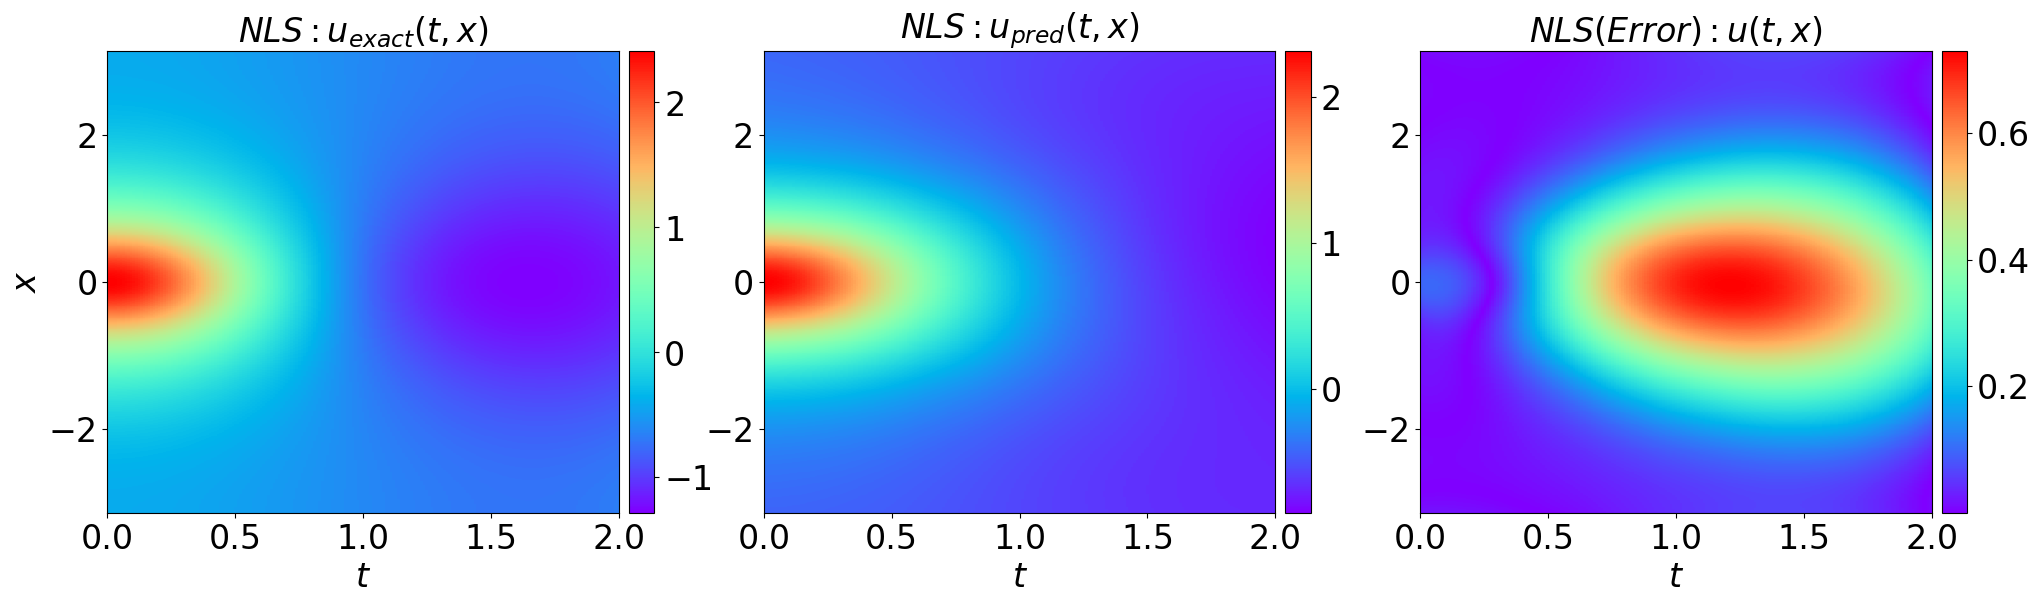

In [25]:
fig = plt.figure(figsize=(24, 6))

ax = plt.subplot(1, 3, 1)
h = ax.imshow(u_sol.T, interpolation='nearest', cmap='rainbow', 
              extent=[tlo, thi, x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=24) 







ax.set_xlabel('$t$', size=24)
ax.set_ylabel('$x$', size=24)

ax.set_title('$NLS: u_{exact}(t,x)$', fontsize = 24) # font size doubled
ax.tick_params(labelsize=24)

ax = plt.subplot(1, 3, 2)
h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
              extent=[tlo, thi, x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=24) 




ax.set_xlabel('$t$', size=24)


ax.set_title('$NLS: u_{pred}(t,x)$', fontsize = 24) # font size doubled
ax.tick_params(labelsize=24)

ax = plt.subplot(1, 3, 3)
h = ax.imshow(np.abs(u_pred-u_sol.T), interpolation='nearest', cmap='rainbow', 
              extent=[tlo, thi, x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=24) 




ax.set_xlabel('$t$', size=24)


ax.set_title('$NLS(Error): u(t,x)$', fontsize = 24) # font size doubled
ax.tick_params(labelsize=24)


plt.show()
fig.savefig('NLS3u_1D_BL.png',format='png')

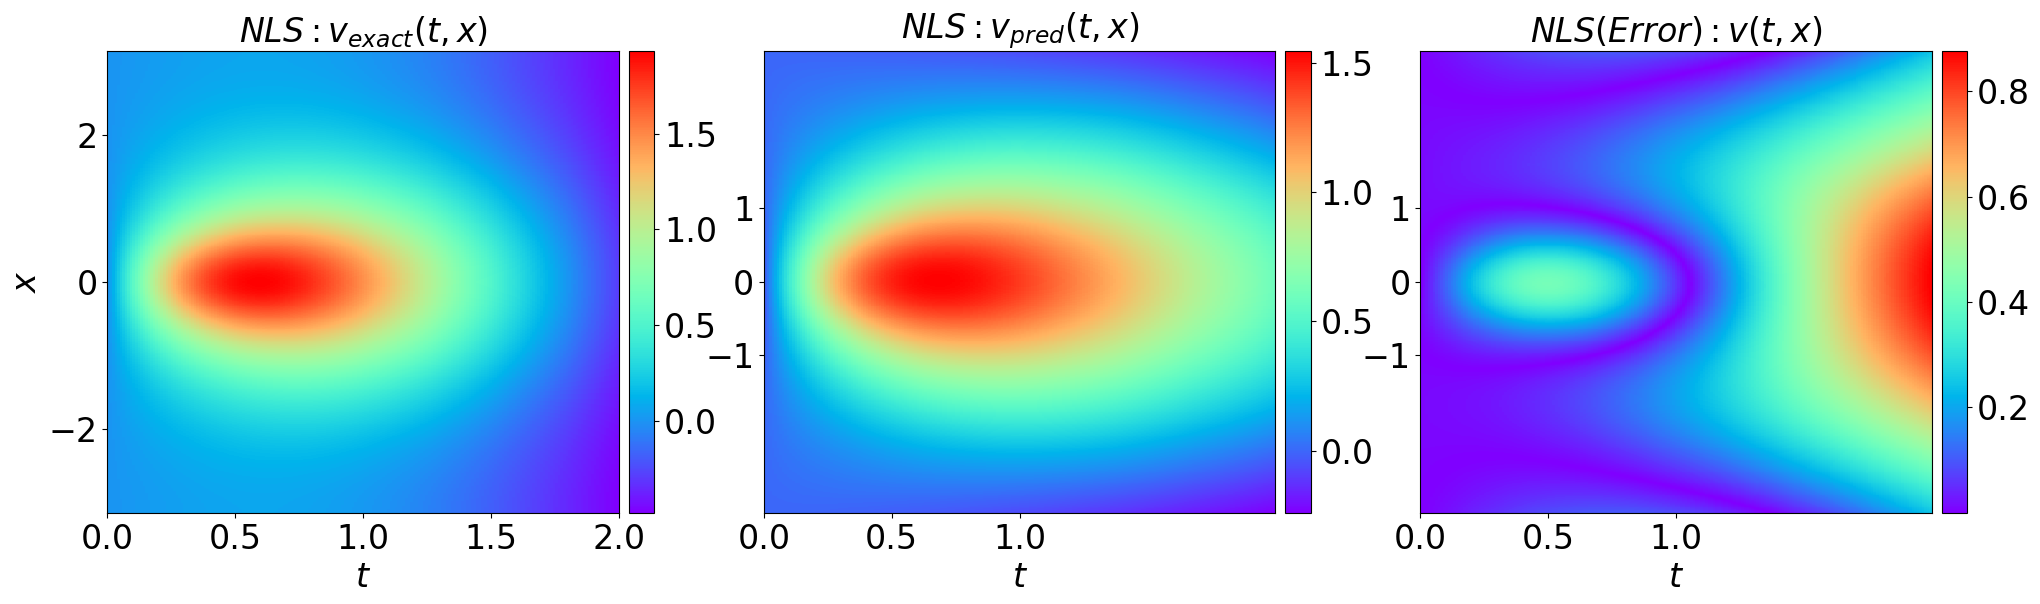

In [24]:
fig = plt.figure(figsize=(24, 6))

ax = plt.subplot(1, 3, 1)
h = ax.imshow(-v_sol.T, interpolation='nearest', cmap='rainbow', 
              extent=[tlo, thi, x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=24) 







ax.set_xlabel('$t$', size=24)
ax.set_ylabel('$x$', size=24)

ax.set_title('$NLS: v_{exact}(t,x)$', fontsize = 24) # font size doubled
ax.tick_params(labelsize=24)

ax = plt.subplot(1, 3, 2)
h = ax.imshow(v_pred, interpolation='nearest', cmap='rainbow', 
              extent=[tlo, thi, x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=24) 




ax.set_xlabel('$t$', size=24)

ax.set_xticks([0 ,0.5 ,1])
ax.set_yticks([-1 ,0 ,1])
ax.set_title('$NLS: v_{pred}(t,x)$', fontsize = 24) # font size doubled
ax.tick_params(labelsize=24)

ax = plt.subplot(1, 3, 3)
h = ax.imshow(np.abs(v_pred+v_sol.T), interpolation='nearest', cmap='rainbow', 
              extent=[tlo, thi, x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=24) 




ax.set_xlabel('$t$', size=24)

ax.set_xticks([0 ,0.5 ,1])
ax.set_yticks([-1 ,0 ,1])
ax.set_title('$NLS(Error): v(t,x)$', fontsize = 24) # font size doubled
ax.tick_params(labelsize=24)


plt.show()
fig.savefig('NLS3v_1D_BL.png',format='png')